In [1]:
"""
Extremely Minimalistic Implementation of DDPM
https://arxiv.org/abs/2006.11239
Everything is self contained. (Except for pytorch and torchvision... of course)
"""

from typing import Dict, Tuple
from tqdm import tqdm

import torch
import torch.nn as nn
from torch.utils.data import DataLoader

from torchvision.datasets import MNIST
from torchvision import transforms
from torchvision.utils import save_image, make_grid
from IPython.display import Image

In [2]:
def ddpm_schedules(beta1: float, beta2: float, T: int) -> Dict[str, torch.Tensor]:
    """
    Returns pre-computed schedules for DDPM sampling, training process.
    """
    assert beta1 < beta2 < 1.0, "beta1 and beta2 must be in (0, 1)"

    beta_t = (beta2 - beta1) * torch.arange(0, T + 1, dtype=torch.float32) / T + beta1
    sqrt_beta_t = torch.sqrt(beta_t)
    alpha_t = 1 - beta_t
    alphabar_t = torch.cumprod(alpha_t, dim=0)

    return {
        "alpha_t": alpha_t,
        "sqrt_beta_t": sqrt_beta_t,
        "alphabar_t": alphabar_t,
    }

In [3]:
print(ddpm_schedules(beta1=1e-4, beta2=0.02, T=10))

{'alpha_t': tensor([0.9999, 0.9979, 0.9959, 0.9939, 0.9919, 0.9900, 0.9880, 0.9860, 0.9840,
        0.9820, 0.9800]), 'sqrt_beta_t': tensor([0.0100, 0.0457, 0.0639, 0.0779, 0.0898, 0.1002, 0.1097, 0.1184, 0.1266,
        0.1342, 0.1414]), 'alphabar_t': tensor([0.9999, 0.9978, 0.9937, 0.9877, 0.9797, 0.9699, 0.9582, 0.9448, 0.9296,
        0.9129, 0.8946])}


In [4]:
class DDPM(nn.Module):
    def __init__(
        self,
        autoencoder_model: nn.Module,
        betas: Tuple[float, float],
        n_T: int,
        criterion: nn.Module = nn.MSELoss(),
    ) -> None:
        super(DDPM, self).__init__()
        self.autoencoder_model = autoencoder_model

        # register_buffer allows us to freely access these tensors by name. It helps device placement.
        for k, v in ddpm_schedules(betas[0], betas[1], n_T).items():
            self.register_buffer(k, v)

        self.n_T = n_T
        self.criterion = criterion

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Implements Algorithm 1 from the paper.
        Makes forward diffusion x_t, and tries to guess epsilon value from x_t using autoencoder_model.
        """

        t = torch.randint(1, self.n_T, (x.shape[0],)).to(x.device)  # t ~ Uniform(0, n_T)
        eps = torch.randn_like(x)  # eps ~ N(0, 1)

        x_t = (
            torch.sqrt(self.alphabar_t[t, None, None, None]) * x
            + torch.sqrt(1 - self.alphabar_t[t, None, None, None]) * eps
        )

        return self.criterion(eps, self.autoencoder_model(x_t))#, t / self.n_T))

    def sample(self, n_sample: int, size, device) -> torch.Tensor:
        """
        Implements Algorithm 2 from the paper.
        """

        x_i = torch.randn(n_sample, *size).to(device)  # x_T ~ N(0, 1)

        for i in range(self.n_T, 0, -1):
            z = torch.randn(n_sample, *size).to(device) if i > 1 else 0
            eps = self.autoencoder_model(x_i) #, i / self.n_T)
            x_i = (
                (1 / torch.sqrt(self.alpha_t[i])) *
                (x_i - eps * (1 - self.alpha_t[i]) / torch.sqrt(1 - self.alphabar_t[i]))
                + self.sqrt_beta_t[i] * z
            )

        return x_i


In [5]:
blk = lambda ic, oc: nn.Sequential(
    nn.Conv2d(ic, oc, 7, padding=3),
    nn.BatchNorm2d(oc),
    nn.LeakyReLU(),
)

class AutoEncoderModel(nn.Module):
    """
    This should be unet-like, but let's don't think about the model too much :P
    Basically, any universal R^n -> R^n model should work.
    """

    def __init__(self, n_channel: int) -> None:
        super(AutoEncoderModel, self).__init__()
        self.conv = nn.Sequential(
            blk(n_channel, 64),
            blk(64, 128),
            blk(128, 256),
            blk(256, 512),
            blk(512, 256),
            blk(256, 128),
            blk(128, 64),
            nn.Conv2d(64, n_channel, 3, padding=1),
        )

    def forward(self, x, t) -> torch.Tensor:
        # Lets think about using t later. Paper uses positional embeddings.
        return self.conv(x)

In [6]:
# UNet code from https://github.com/milesial/Pytorch-UNet/tree/master

import torch
import torch.nn as nn
import torch.nn.functional as F


class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""

    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)


class Down(nn.Module):
    """Downscaling with maxpool then double conv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)


class Up(nn.Module):
    """Upscaling then double conv"""

    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()

        # if bilinear, use the normal convolutions to reduce the number of channels
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        # if you have padding issues, see
        # https://github.com/HaiyongJiang/U-Net-Pytorch-Unstructured-Buggy/commit/0e854509c2cea854e247a9c615f175f76fbb2e3a
        # https://github.com/xiaopeng-liao/Pytorch-UNet/commit/8ebac70e633bac59fc22bb5195e513d5832fb3bd
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)


class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)


class UNet(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=False):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        self.inc = (DoubleConv(n_channels, 64))
        self.down1 = (Down(64, 128))
        self.down2 = (Down(128, 256))
        self.down3 = (Down(256, 512))
        factor = 2 if bilinear else 1
        self.down4 = (Down(512, 1024 // factor))
        self.up1 = (Up(1024, 512 // factor, bilinear))
        self.up2 = (Up(512, 256 // factor, bilinear))
        self.up3 = (Up(256, 128 // factor, bilinear))
        self.up4 = (Up(128, 64, bilinear))
        self.outc = (OutConv(64, n_classes))

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return logits

In [7]:
import tonic
import torchvision

def train_frames(epochs:int=100, diffusion_steps:int=1000, lr=2e-4, device="cuda:0", batch_size=12) -> None:

    # ddpm = DDPM(autoencoder_model=AutoEncoderModel(1), betas=(1e-4, 0.02), n_T=diffusion_steps)
    ddpm = DDPM(autoencoder_model=UNet(1,1), betas=(1e-4, 0.02), n_T=diffusion_steps)
    ddpm.to(device)

    transform=torchvision.transforms.Compose([
        torch.as_tensor,
        lambda x: x.float().unsqueeze(1) / x.max(),
        torchvision.transforms.CenterCrop((180, 180)),
        torchvision.transforms.Resize((90,90)),
        torchvision.transforms.Normalize((0.5,), (0.5)),
        ]) # convert to [-1, 1] range

    def frame_transform(data):
        events, imu, frames = data
        frames = transform(frames['frames'])
        return frames # events, imu,

    # dataset = tonic.datasets.DAVISDATA(save_to="data", recording=["shapes_6dof", "shapes_translation" , "shapes_rotation"], transform=frame_transform)
    # dataset = tonic.datasets.DAVISDATA(save_to="data", recording=["slider_close", "slider_far" , "slider_hdr_close", "slider_hdr_far", "slider_depth"], transform=frame_transform)
    dataset = tonic.datasets.DAVISDATA(save_to="data", recording="all", transform=frame_transform)
    
    frames = torch.empty(0, 1, 90, 90)
    for imgs, targets in dataset:
        frames = torch.cat((frames, imgs))

    print(frames.shape)
    dataloader = torch.utils.data.DataLoader(frames, batch_size=batch_size, shuffle=True, num_workers=4)

    optim = torch.optim.Adam(ddpm.parameters(), lr=lr)

    for i in range(epochs):
        ddpm.train()

        progress_bar = tqdm(dataloader)
        loss_current = None
        for x in progress_bar:
            optim.zero_grad()
            x = x.to(device)
            loss = ddpm(x)
            loss.backward()
            if loss_current is None:
                loss_current = loss.item()
            else:
                loss_current = 0.9 * loss_current + 0.1 * loss.item()
            progress_bar.set_description(f"loss: {loss_current:.4f}")
            optim.step()

        ddpm.eval()
        with torch.no_grad():
            xh = ddpm.sample(4, (1, 90, 90), device)
            grid = make_grid(xh, nrow=4)
            save_image(grid, f"./images/ddpm_sample_{i}.png")
            display(Image(f"./images/ddpm_sample_{i}.png", width=600, height=600))

            # save model
            torch.save(ddpm.state_dict(), f"./ddpm_mnist.pth")

    display(Image(f"./images/ddpm_sample_{epochs-1}.png", width=600, height=600))

torch.Size([27259, 1, 90, 90])


loss: 0.0360: 100%|██████████| 2272/2272 [02:46<00:00, 13.66it/s]


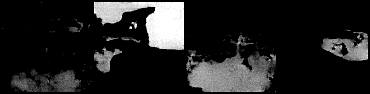

loss: 0.0272: 100%|██████████| 2272/2272 [02:38<00:00, 14.32it/s]


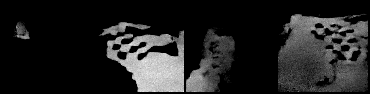

loss: 0.0227: 100%|██████████| 2272/2272 [02:38<00:00, 14.30it/s]


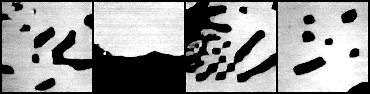

loss: 0.0260:  97%|█████████▋| 2195/2272 [02:33<00:05, 14.31it/s]

In [8]:
train_frames(epochs=30, diffusion_steps=1000, batch_size=64) # diffusion_steps aka T

31.036481